# Comparing magnitudes with SIMBAD

Written by Evgenii N.

## Prerequisite code

In [1]:
# Import libraries that we will use later in this notebook
import os
import matplotlib.pyplot as plt
import pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import pandas as pd
import scipy
from scipy import stats
import numpy as np
import subprocess
import shutil
import re
import math
from io import StringIO
from shutil import copyfile
from shutil import which
from ccdproc import CCDData
from photutils.aperture import CircularAperture
from astropy.visualization import ZScaleInterval, MinMaxInterval, ImageNormalize

# Make images non-blurry on high pixel density screens
%config InlineBackend.figure_format = 'retina'


def set_plot_style():
    """Set global style"""
    
    plt.rcParams['font.family'] = 'serif'
    
    TINY_SIZE = 15
    SMALL_SIZE = 18
    NORMAL_SIZE = 22
    LARGE_SIZE = 25

    # Title size
    plt.rcParams['axes.titlesize'] = LARGE_SIZE

    # Axes label size
    plt.rcParams['axes.labelsize'] = NORMAL_SIZE

    # Tick label size
    plt.rcParams['xtick.labelsize'] = TINY_SIZE
    plt.rcParams['ytick.labelsize'] = TINY_SIZE
    
    # Legend text size
    plt.rcParams['legend.fontsize'] = SMALL_SIZE
    
    plt.rcParams['font.size'] = NORMAL_SIZE
    plt.rcParams['legend.fontsize'] = NORMAL_SIZE
    

    # Grid color
    plt.rcParams['grid.color'] = '#cccccc'

    # Define plot size
    plt.rcParams['figure.figsize'] = [12, 8]

    # Marker size
    plt.rcParams['lines.markersize'] = 13


set_plot_style()

In [2]:
def show_image(image, title, apertures=None, plot_dir=None, file_name=None,
              colorbar_fraction_width=0.05, pad_fraction=0.5, show=True):
    """
    Display an image.
    
    Parameters
    ---------
    
    image: astropy.nddata.ccddata.CCDData
        A fits image to show.
        
    title: str
        Plot title.
        
    apertures: list of CircularAperture
        List of apertures to plot over the image, optional.
        
    plot_dir: str
        Directory where the plot file is saved.
        
    file_name: str
        Name of the file where the plot is saved.
        
    colorbar_fraction_width: float
        The width of the colorbar relative to the image width.
        
    pad_fraction: float
        The size of the margin between the plot and the colorbar, relative
        to the colorbar width.
        
    show: bool
        If False, do not or save the image
        
        
    Returns
    -------
    fig, ax
        Matplotlib's figure and axis for the plot.
    """
    
    fig, ax = plt.subplots()
    
    # Scale the image similar to 'zscale' mode in DS9.
    # This makes easier to spot things in the image.
    interval=ZScaleInterval()
    vmin, vmax = interval.get_limits(image)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    
    plt.imshow(image, cmap='gray', norm=norm)  # Set color map and pixel scaling
    
    if apertures is not None:
        apertures.plot(color='#33ff33', lw=1.5, alpha=0.8)
    
    # Show the colorbar
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=colorbar_fraction_width)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.colorbar(cax=cax)

    # Set axis labels
    ax.set_xlabel('x [pixel]')  
    ax.set_ylabel('y [pixel]')

    fig.tight_layout()
    
    if show:
        # Save to file, show and close
        save_plot(fig, plot_dir=plot_dir, file_name=file_name)
        plt.show(fig)
        plt.close(fig)
        
        # Print plot label
        print(title)
        print()
        
    
    return fig, ax
    
    

def save_plot(fig, plot_dir, file_name):
    """
    Save a plot to a file.
    
    Parameters
    ----------
    
    fig: matplotlib.figure.Figure
        Plot's figure
        
    plot_dir: str
        Directory where the plot file is placed.
        
    file_name: str
        Plot file name
    
    """
    
    if file_name is None:
        return
    
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    image_path = os.path.join(plot_dir, file_name)

    plt.savefig(image_path, fig=fig, dpi=150, transparent=False,
                bbox_inches='tight', pad_inches=0.1)

## Comparing magnitudes of stars with Simbad

Michael Brown asked on the forum:

> How does your photometry of the brightest stars compare with Simbad/Aladin? 

I want to compare B and V magnitudes that I measure with ones from SIMBAD:

* I manually select 20+ that comver range of magnitudes from 14 to 17.

* Make sure those stars are not reference stars.

* Write down x,y coordinate of the stars in `data/star_check.csv` file.

* Locate those stars on [AladinLite](https://aladin.u-strasbg.fr/AladinLite/) web site, and write down their SIMBAD B and V magnitudes.

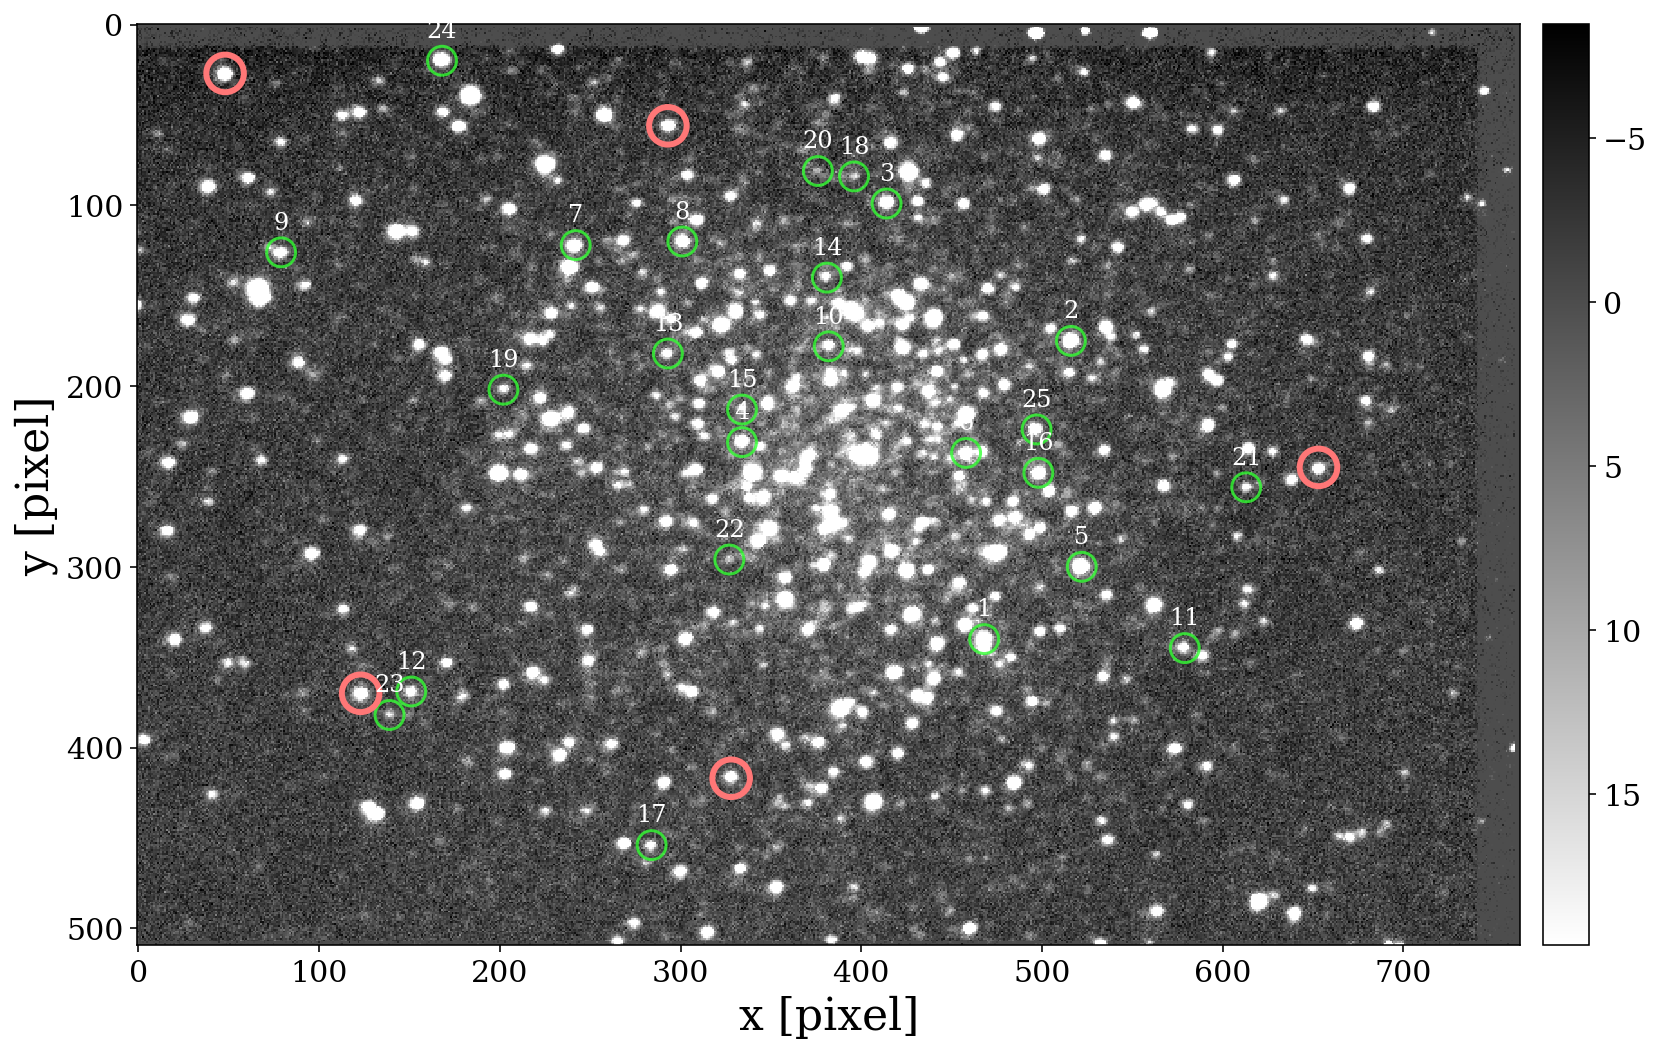

In [3]:
def plot_stars(image, positions, star_numbers, aperture_radius,
               reference_stars, title):
    """
    Plot the image and show positions of the stars on it.
    
    Parameters
    ----------
    
    image: astropy.nddata.ccddata.CCDData
        An image to the stars in.
        
    positions: list of (x, y)
        Position of all stars in the image.
        
    star_numbers: list of int
        Star numbers.
        
    aperture_radius: flost
        Radius of the star's aperture.
        
    reference_stars: pandas.core.frame.DataFrame
        A table containing positions of reference stars.
    """
    
    apertures = CircularAperture(positions, r=aperture_radius)
    fig, ax = show_image(image=image, apertures=apertures, title=title, show=False)
    
    reference_positions = [
        (star[0], star[1])
        for star in reference_stars[["non_photometric_x", "non_photometric_y"]].values
    ]
    
    reference_apertures = CircularAperture(reference_positions, r=aperture_radius * 1.3) 
    reference_apertures.plot(color='#ff7777', lw=3, alpha=1, axes=ax)
    
    
    for number, position in zip(star_numbers, positions):
        ax.text(x=position[0], y=position[1] - 13, s=str(number), color="white",
                horizontalalignment='center', fontsize=12)
        
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.show()
    

def load_check_stars(star_check_path, figure_number, aperture_radius):
    """
    Load the stars I want to verify and plot them
    
    Parameters
    -----------
    
    star_check_path: str
        Path to CSV file containing positions of the check stars.
        
    figure_number: int
        Figure number to be shown in plot caption.
        
    aperture_radius: float
        Radius of aperture that will be used for marking check stars in the plot.
        
    Returns
    -------
    pandas.core.frame.DataFrame
        Table containing the check stars and their magnitudes.
    """
    
    # Load stars we want to check
    df_star_check = pd.read_csv(star_check_path, index_col="star_number")
    star_check_positions = df_star_check[['x', 'y']].values

    reference_stars_path = os.path.join("../060_find_magnitudes/data", "reference_stars.csv")
    reference_stars = pd.read_csv(reference_stars_path, index_col="star_number")

    # Read V filter image
    # --------

    non_photometric_dir = "../050_scaling_and_combining/march_09_2018_stacked"
    filter_name = "B"

    # Set path to non-photometric image
    image_path = os.path.join(non_photometric_dir,
                              f'NGC_3201_{filter_name.lower()}_median_60.0s.fits')

    # Read non-photometric image
    image = CCDData.read(image_path)

    figure_number += 1

    title = (
        f"Figure {figure_number}: Stars selected for verification (green circles), {filter_name} filter. \n"
        "Red circles are the reference stars used for calculating magnitudes in photometric image."
    )

    plot_stars(image=image, positions=star_check_positions,
               star_numbers=df_star_check.index.values,
               aperture_radius=aperture_radius,
               reference_stars=reference_stars, title=title)
    
    # Load all stars
    magnitudes_dir = "../060_find_magnitudes/data"
    magnitudes_path = os.path.join(magnitudes_dir, "magnitudes.csv")
    df_all_stars = pd.read_csv(magnitudes_path)

    # Drop rows with missing values
    df_star_check = df_star_check.dropna(subset=["b_mag_simbad", "v_mag_simbad"])

    # Join two tables
    df_star_check['star_no'] = df_star_check.index
    df_joined = df_star_check.merge(df_all_stars, how='inner', left_on=['x','y'],right_on=['x','y'])
    
    return df_joined
   
star_check_path = os.path.join("data", "star_check.csv")
figure_number = 1

df_check_stars = load_check_stars(star_check_path=star_check_path,
                                  figure_number=figure_number, aperture_radius=8)

Stars selected for verification are shown on Figure 115.

## Plot our vs SIMBAD magnitudes

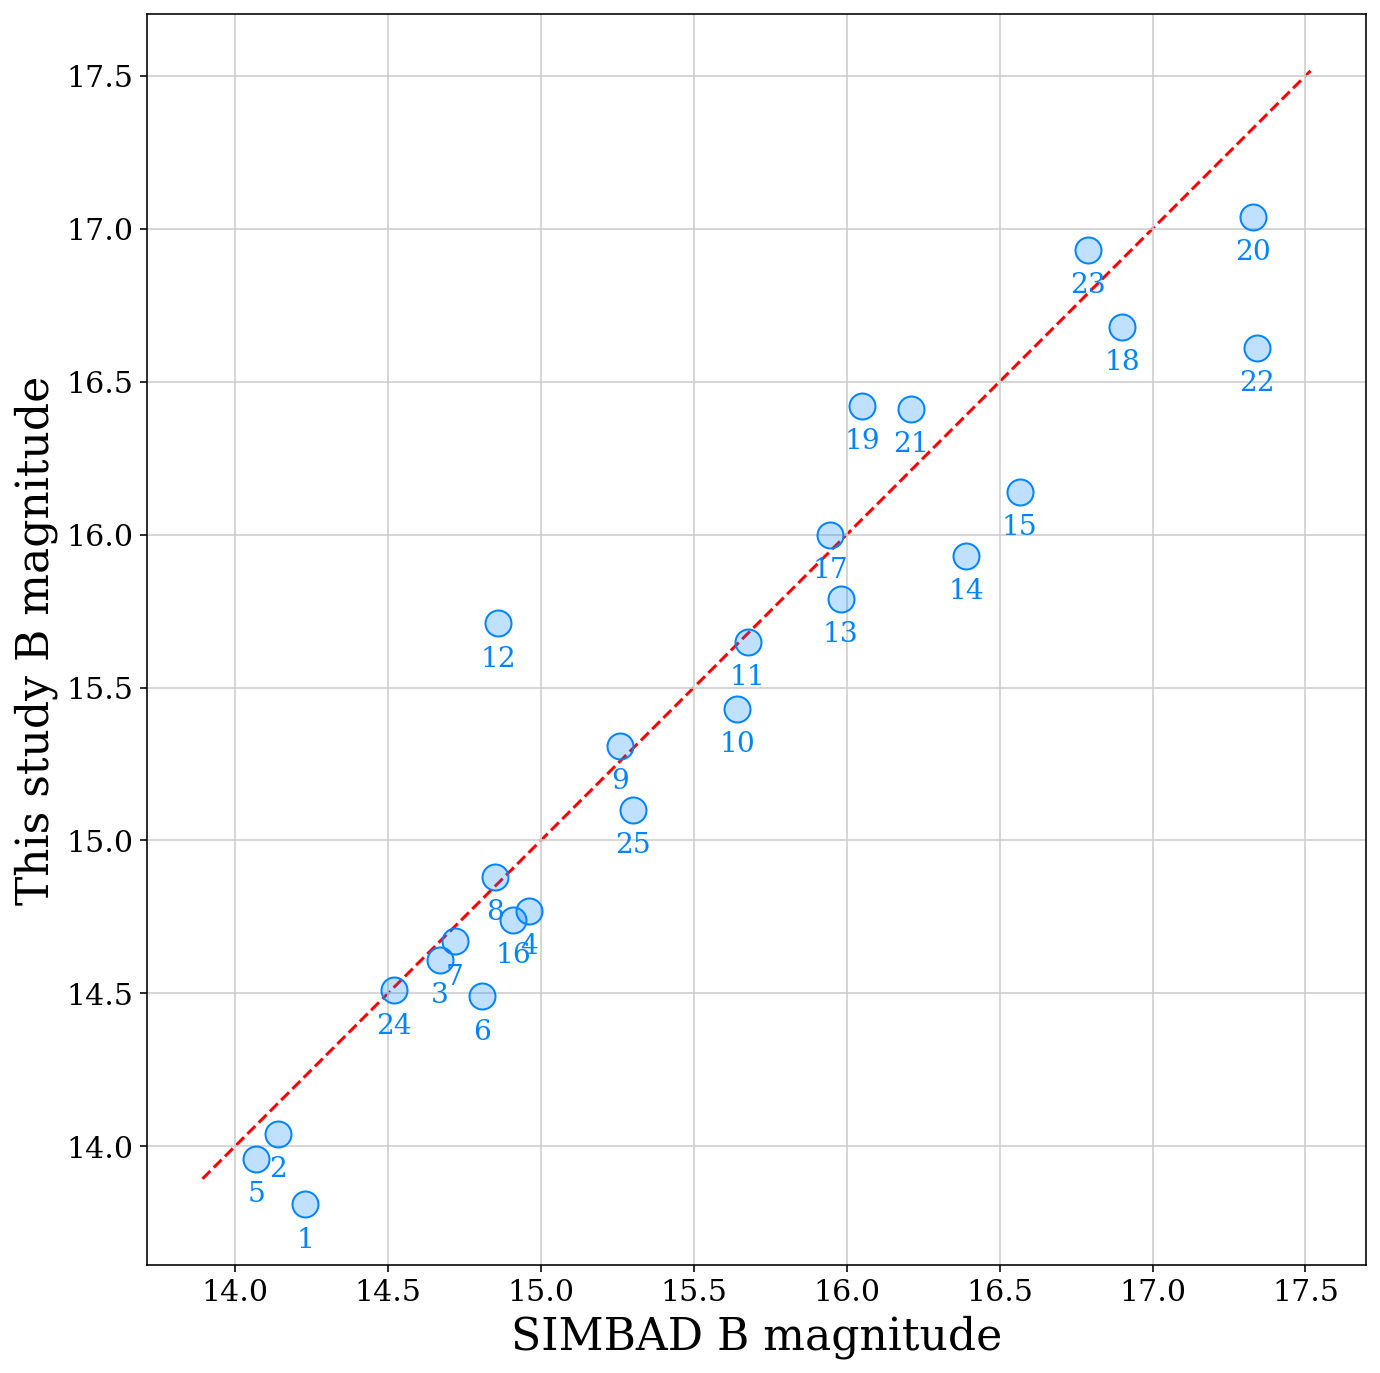

Figure 121: Compare measured B apparent magnitude with SIMBAD.



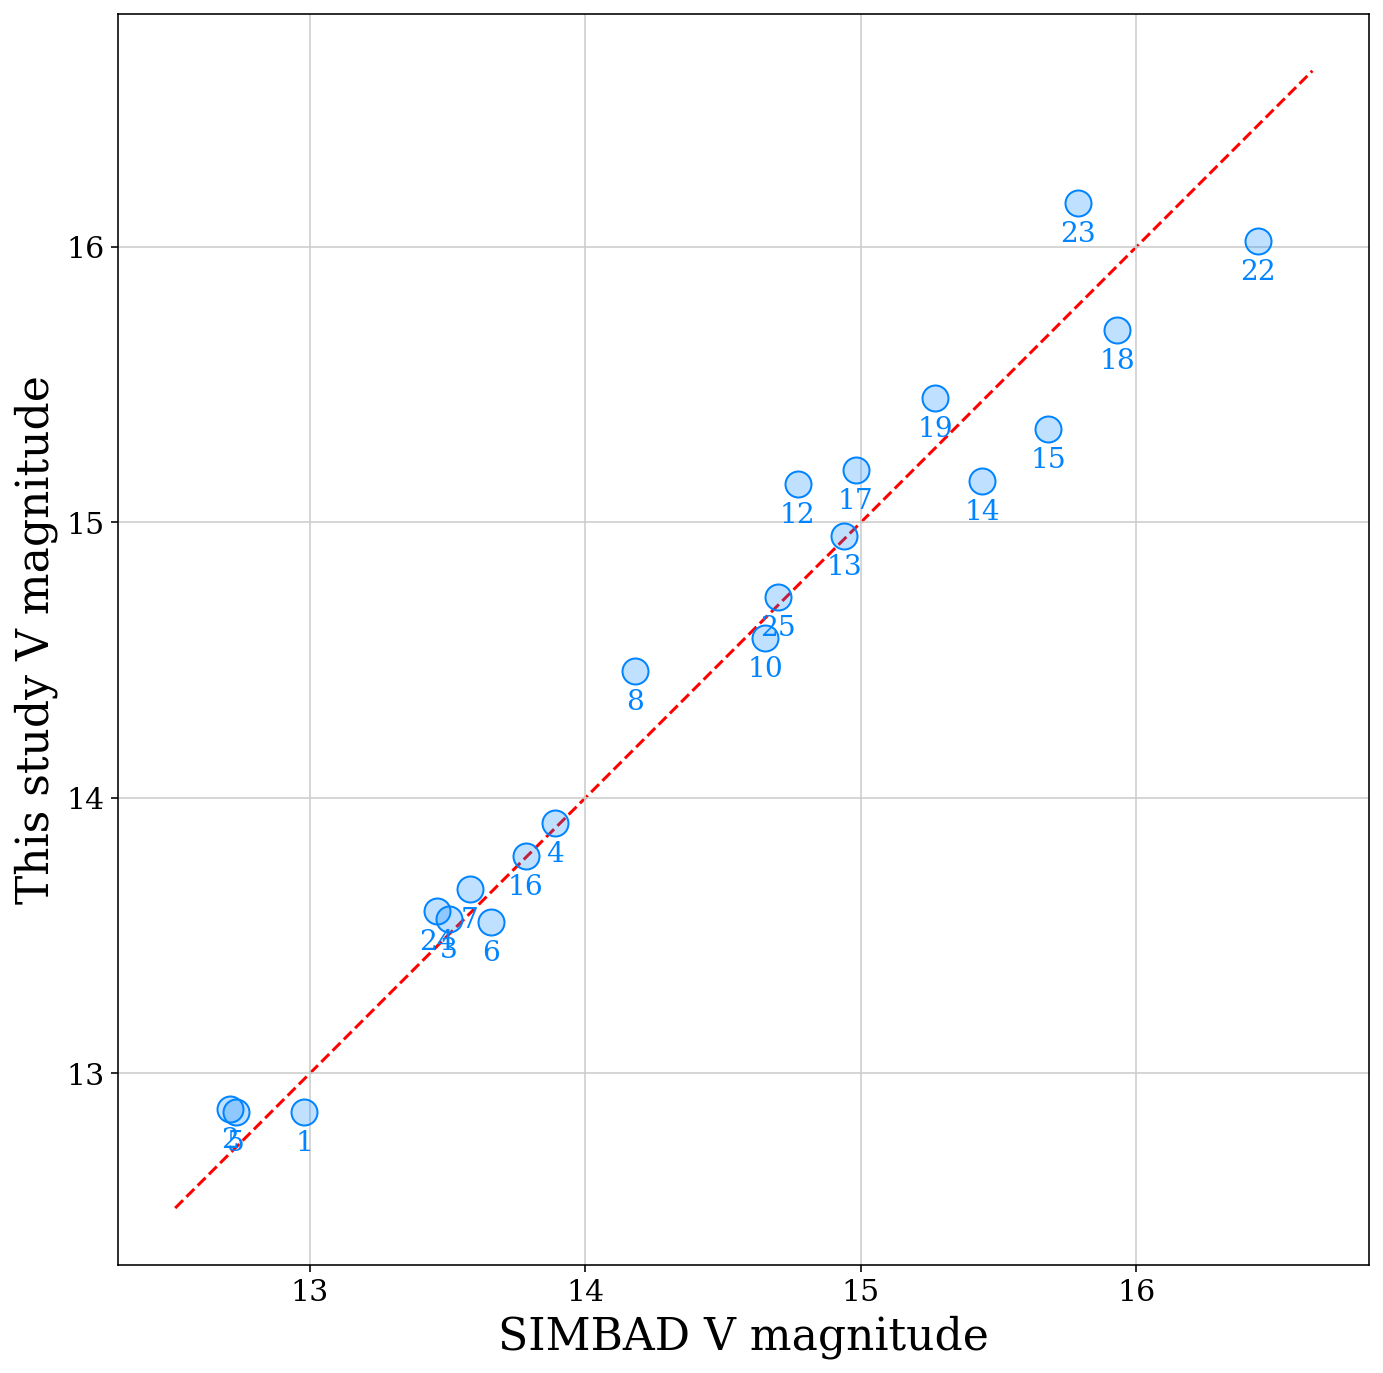

Figure 122: Compare measured V apparent magnitude with SIMBAD.



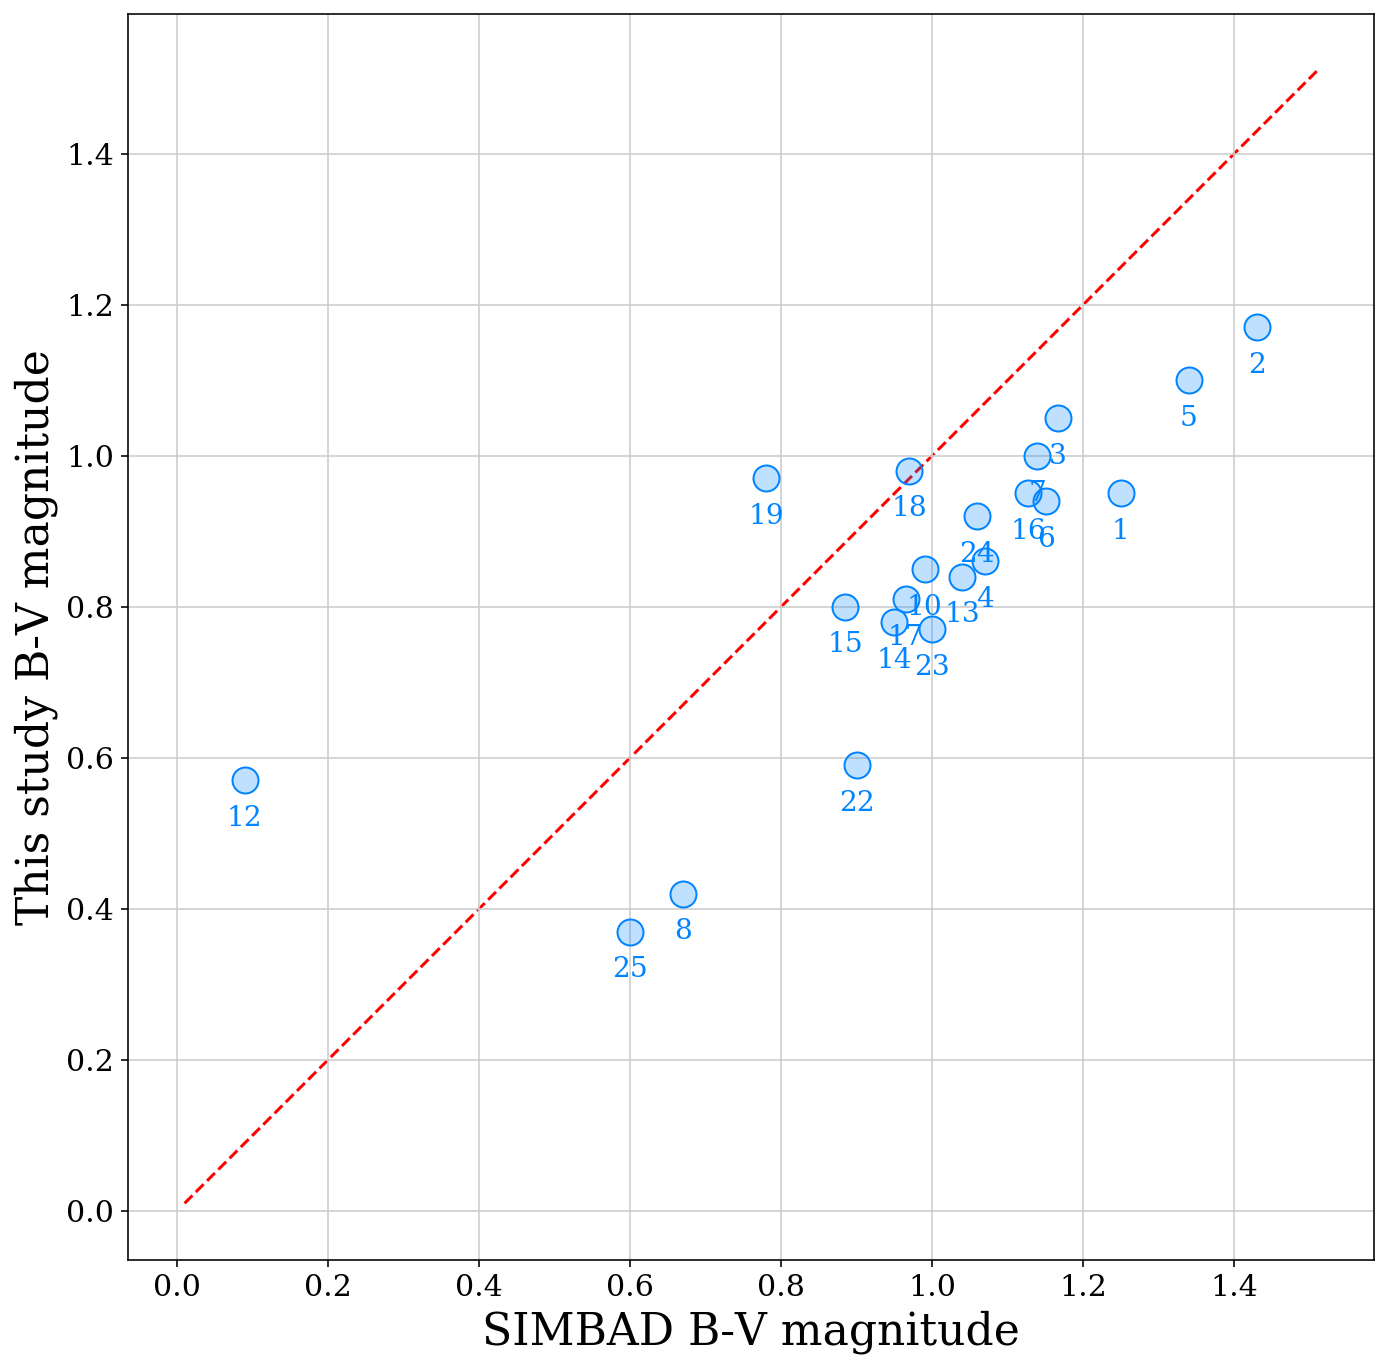

Figure 123: Compare measured B-V apparent magnitude with SIMBAD.



In [4]:
def plot_simbad_vs_our_mag(df, filter_name, figure_number, plot_dir, star_label_offset):
    """
    Plot magnitudes from Simbad vs ours.
    
    Parameters
    ---------
    
    df: pandas.core.frame.DataFrame
        Table containing the magnitudes.
        
    filter_name: str
        Filter name: "V", "B" etc
    """

    filter_name = filter_name.lower()
    fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    
    # Drop rows with empty magnitudes
    df = df.dropna(subset=[f"{filter_name}_mag"])
    
    # Show scatter plots
    x_values = df[f"{filter_name}_mag_simbad"]
    y_values = df[f"{filter_name}_mag"]
    ax.scatter(x_values, y_values, color="#0084ff40", edgecolor="#0084ff", zorder=2)

    for b_simbad, b_mag, no in zip(x_values, y_values, df["star_no"]):
        ax.text(b_simbad, b_mag + star_label_offset, s=no, horizontalalignment='center', fontsize=14,
               color="#0084ff")
        
    # Plot diagonal
    xlim = ax.get_xlim()
    ax.plot(xlim, xlim, linestyle='dashed', color="red", zorder=1)
        
    # Show grid
    ax.grid()

    # Set plot labels
    ax.set_xlabel(f"SIMBAD {filter_name.upper()} magnitude")
    ax.set_ylabel(f"This study {filter_name.upper()} magnitude")
                         
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    
    plot_file_name = f"simbad_vs_us_{filter_name}.pdf"
    save_plot(fig, plot_dir=plot_dir, file_name=plot_file_name)
    plt.show(fig)
    plt.close(fig)
    
    # Print cations
    title = f"Figure {figure_number}: Compare measured {filter_name.upper()} apparent magnitude with SIMBAD." 
    print(title)
    print()
    
    
figure_number = 120
plot_dir = "images"

# Calcualte B-V magnitude
# -------

df_check_stars["b-v_mag"] = df_check_stars["b_mag"] - df_check_stars["v_mag"]
df_check_stars["b-v_mag_simbad"] = df_check_stars["b_mag_simbad"] - df_check_stars["v_mag_simbad"]

# Show plot
# -------

plot_settings = [
    dict(filter_name='B', star_label_offset=-0.14),
    dict(filter_name='V', star_label_offset=-0.14),
    dict(filter_name='B-V', star_label_offset=-0.06),
]

for settings in plot_settings:
    figure_number += 1
    
    plot_simbad_vs_our_mag(df=df_check_stars,
                           filter_name=settings['filter_name'],
                           figure_number=figure_number,
                           star_label_offset=settings['star_label_offset'],
                           plot_dir=plot_dir)

I can see from Figures 120 and 121 that my magnitudes differ from SIMBAD more for fainter stars. This makes sense, since singnal-to-noise is lower for fainter stars. Let's compare B-V.

## Plot SIMBAD - our magnitudes

Let's print the different between SIMBAD and our magnitudes.

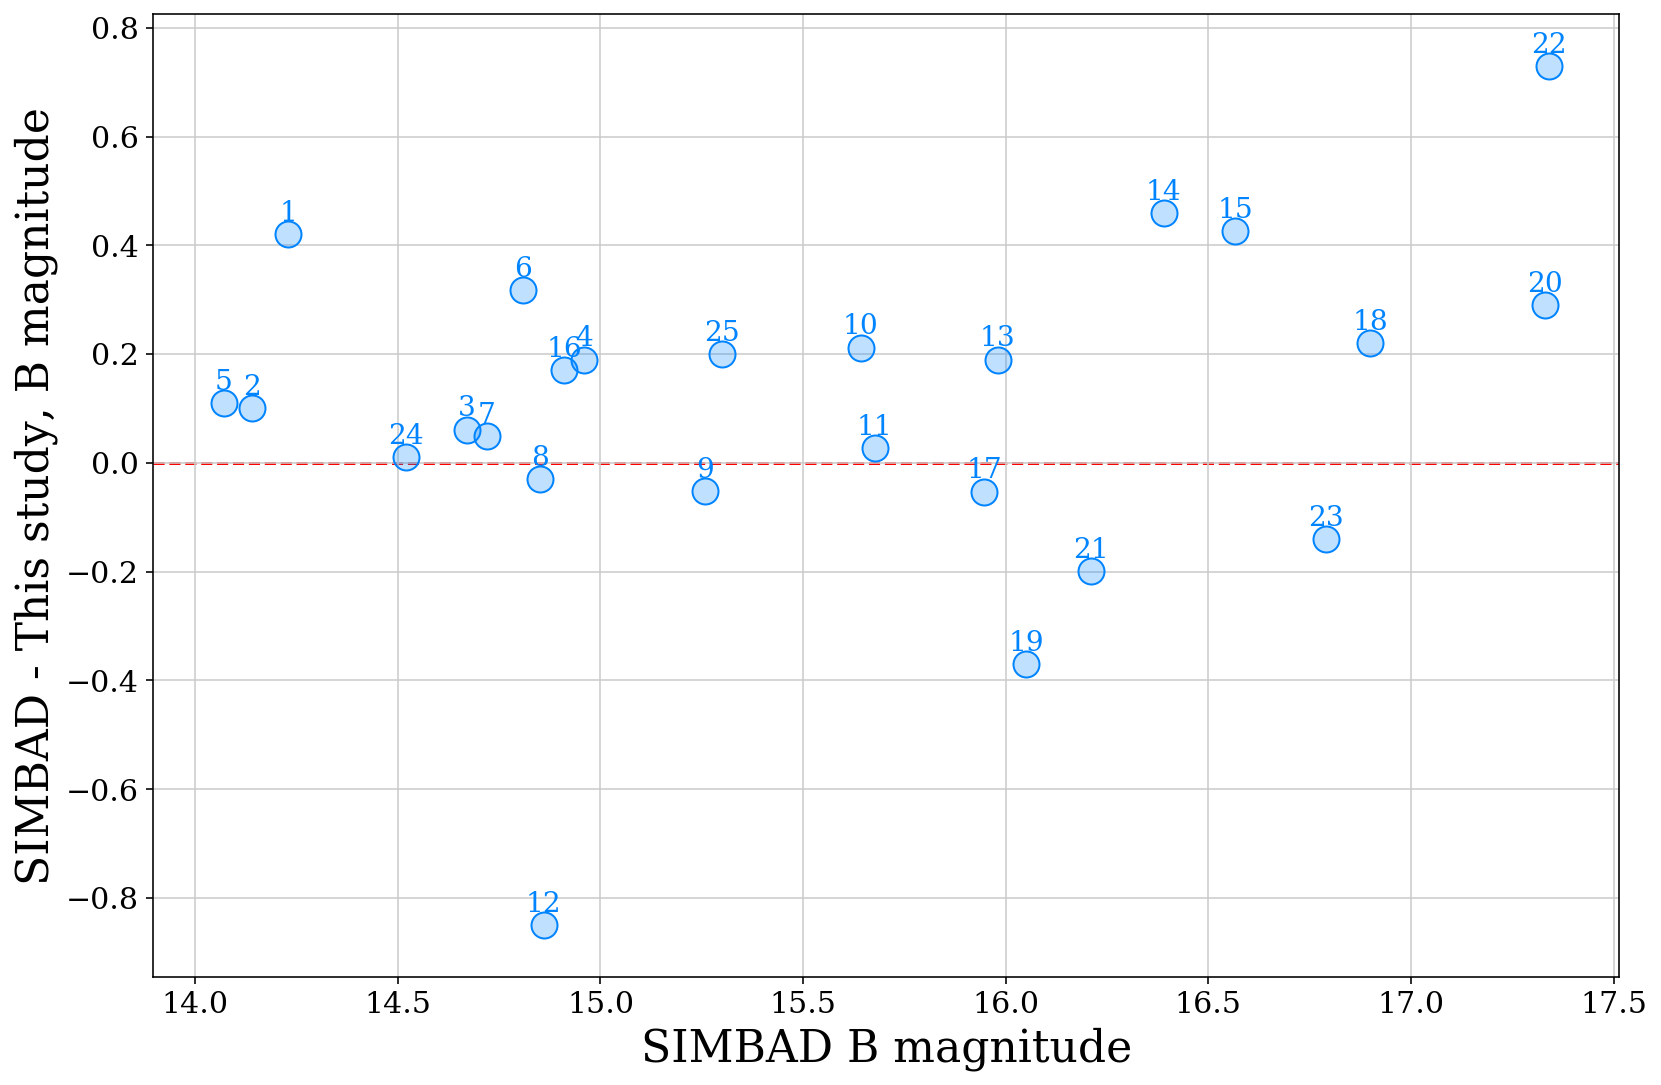

Figure 124: Compare B measured apparent magnitude with SIMBAD.



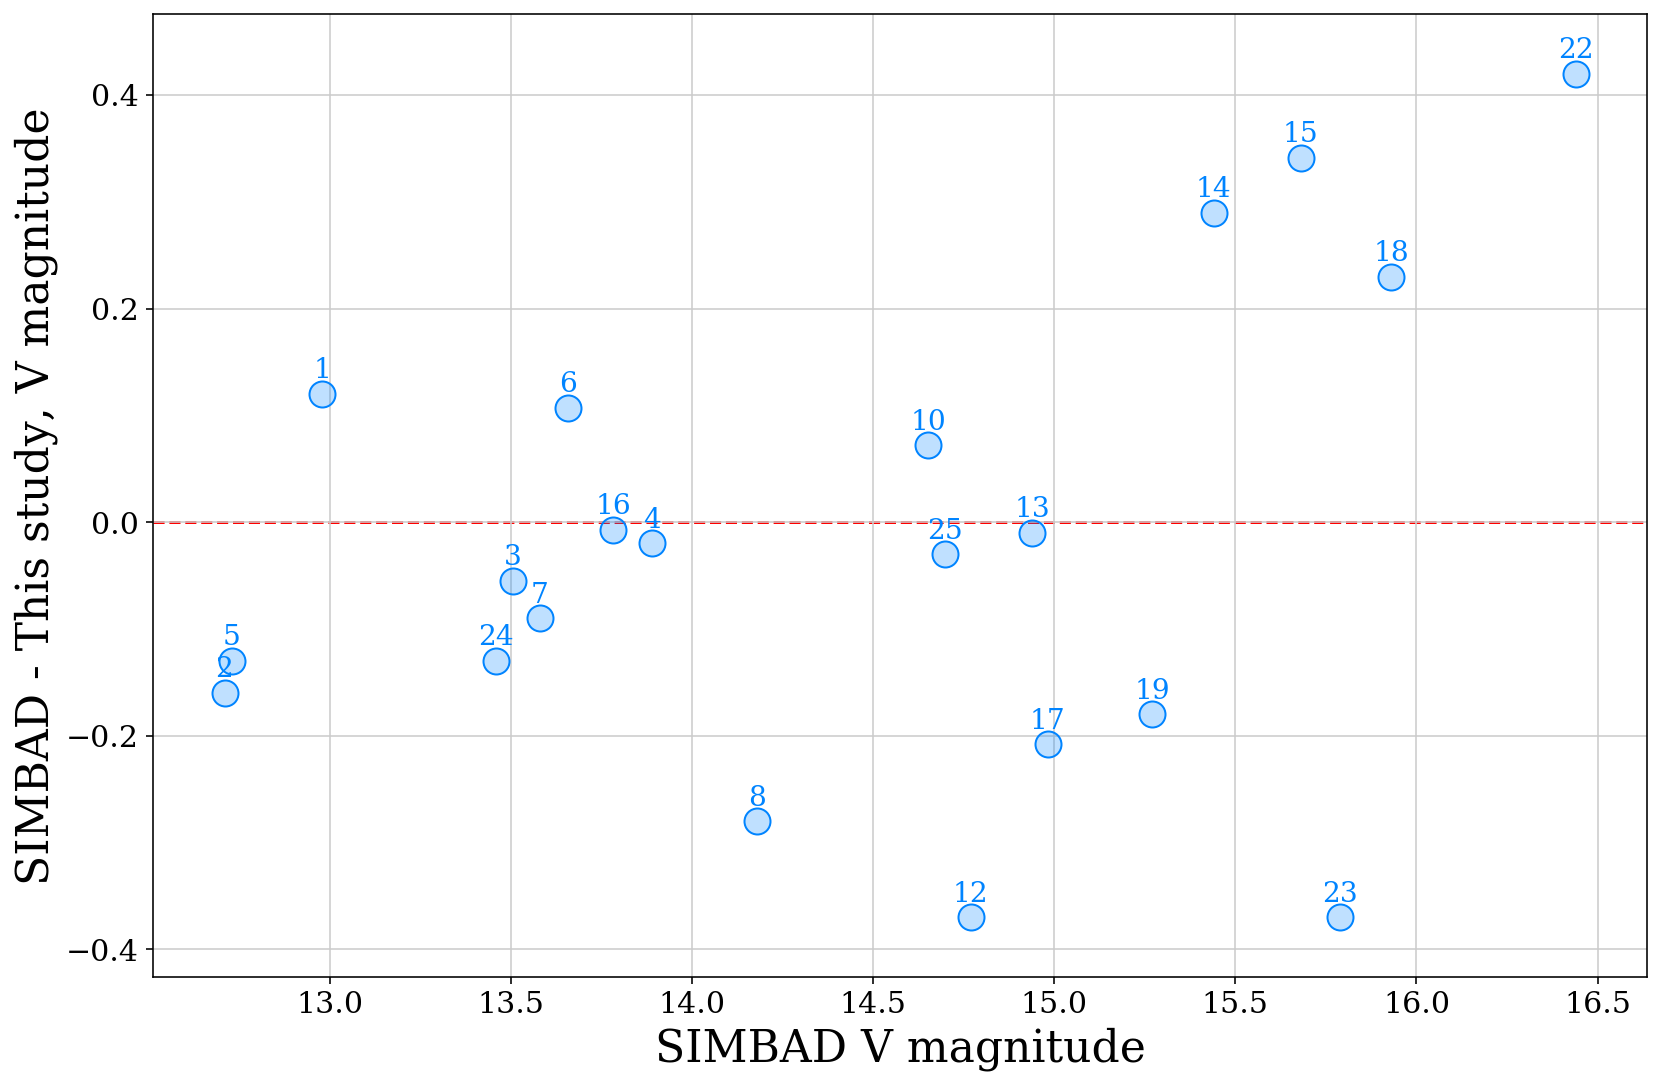

Figure 125: Compare V measured apparent magnitude with SIMBAD.



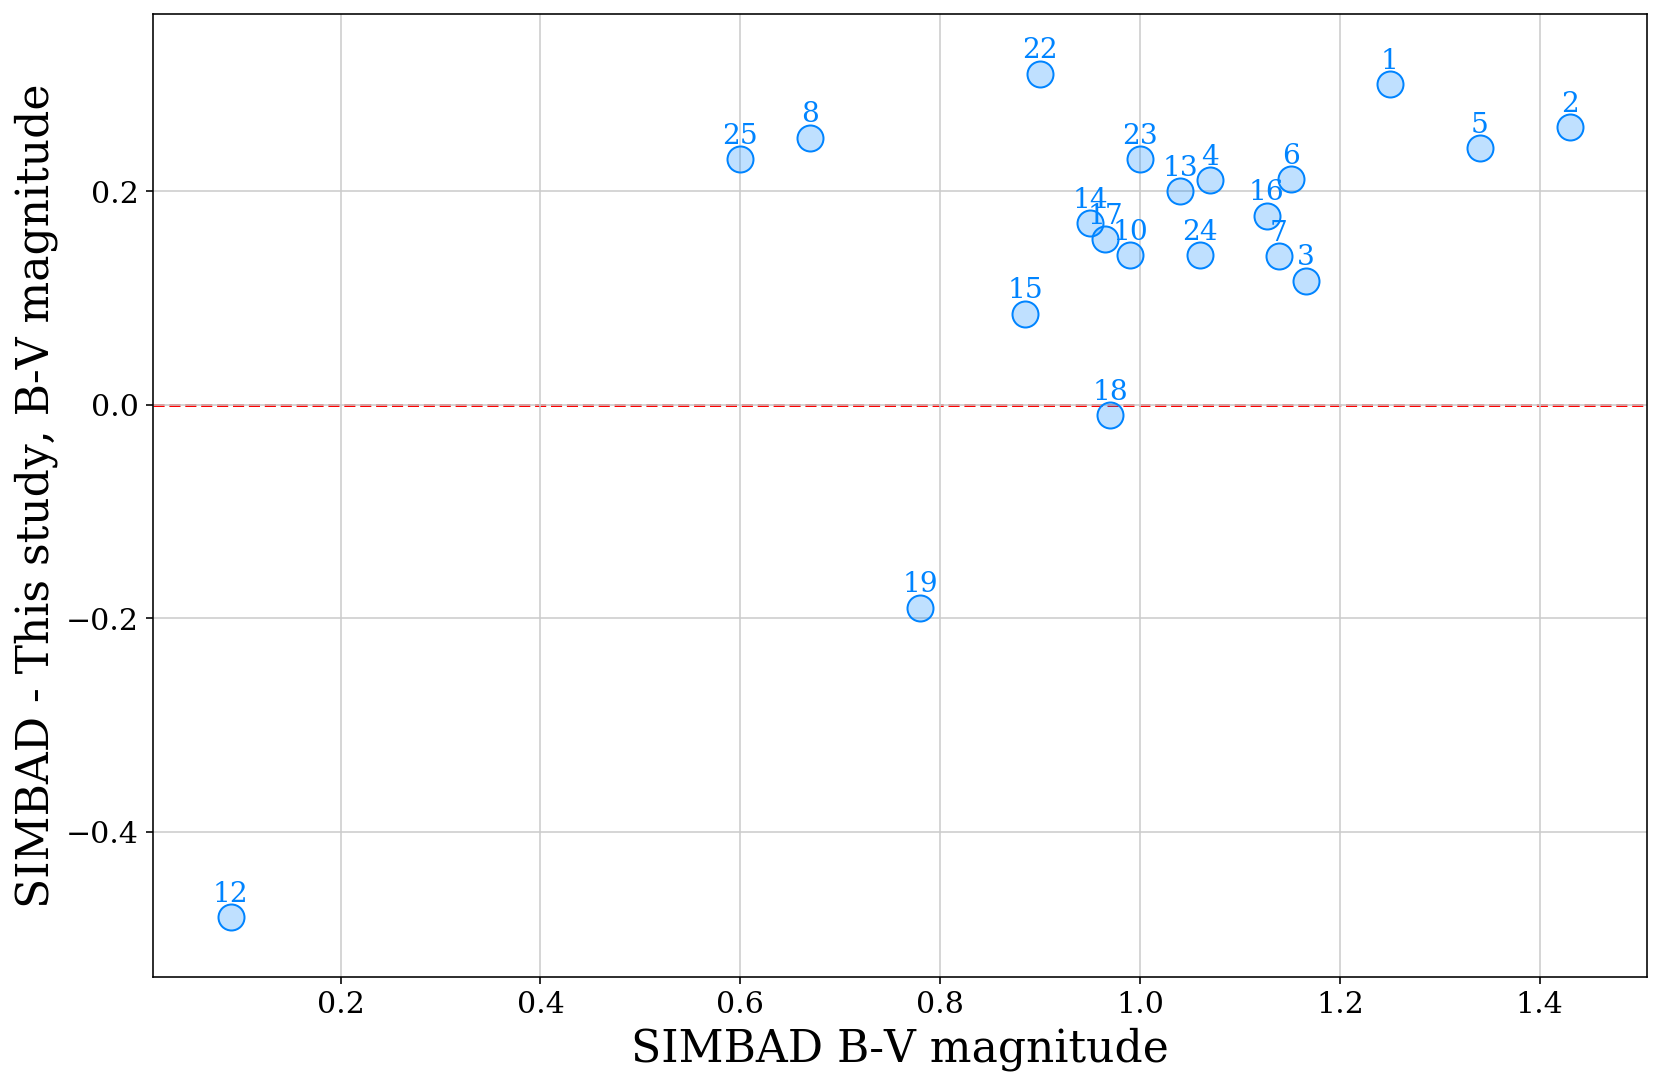

Figure 126: Compare B-V measured apparent magnitude with SIMBAD.



In [5]:
def plot_difference_from_simbad(df, filter_name, figure_number, number_offset, plot_dir):
    """
    Plot magnitudes from Simbad vs ours.
    
    Parameters
    ---------
    
    df: pandas.core.frame.DataFrame
        Table containing the magnitudes.
        
    filter_name: str
        Filter name: "V", "B" etc.
        
    number_offset: float
        y-offset for the star label. 
    """

    filter_name = filter_name.lower()
    fig, ax = plt.subplots(1, 1)
    
    # Drop rows with empty magnitudes
    df = df.dropna(subset=[f"{filter_name}_mag"])
    
    y_values = df[f"{filter_name}_mag_simbad"] - df[f"{filter_name}_mag"]
    
    # Show scatter plots
    ax.scatter(df[f"{filter_name}_mag_simbad"], y_values,
               color="#0084ff40",
               edgecolor="#0084ff", zorder=2)
    
    # Plot zero
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, (0, 0), linestyle='dashed', color="red", zorder=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    for x, y, no in zip(
        df[f"{filter_name}_mag_simbad"],
        y_values, df["star_no"]):
        ax.text(x, y + number_offset, s=no, horizontalalignment='center',
                fontsize=14, color="#0084ff")
        
    # Show grid
    ax.grid()

    # Set plot labels
    ax.set_xlabel(f"SIMBAD {filter_name.upper()} magnitude")
    ax.set_ylabel(f"SIMBAD - This study, {filter_name.upper()} magnitude")       
    plt.tight_layout()
    
    plot_file_name = f"offset_from_simbad_{filter_name}.pdf"
    save_plot(fig, plot_dir=plot_dir, file_name=plot_file_name)
    plt.show(fig)
    plt.close(fig)
    
    # Print caption
    title = f"Figure {figure_number}: Compare {filter_name.upper()} measured apparent magnitude with SIMBAD." 
    print(title)
    print()

plot_dir = "images"

plot_settings = [
    dict(filter_name='B', number_offset=0.025),
    dict(filter_name='V', number_offset=0.015),
    dict(filter_name='B-V', number_offset=0.015),
]

for settings in plot_settings:    
    figure_number += 1
    plot_difference_from_simbad(df=df_check_stars,
                                filter_name=settings['filter_name'],
                                figure_number=figure_number,
                                number_offset=settings['number_offset'],
                                plot_dir=plot_dir)

## Make boxplots of SIMBAD - our magnitudes

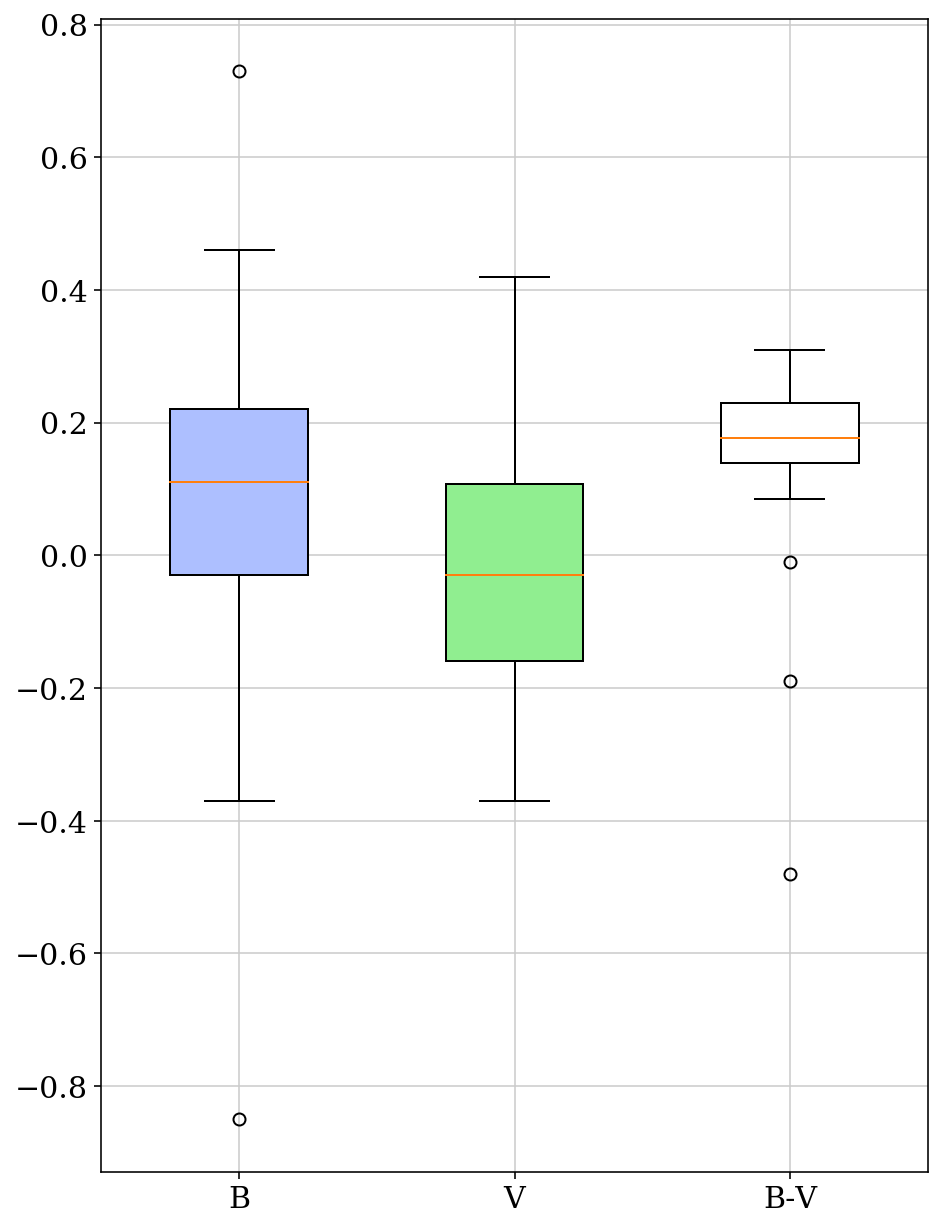

Figure 127: Compare measured apparent magnitudes:
SIMBAD - this study.



In [6]:
# The default colors used for box plots
BOXPLOT_COLORS = ['#adbfff', 'lightgreen', 'white']
DEFAULT_COLOR = 'khaki'


def compare_boxplots(groups, labels, plot_dir, colors=BOXPLOT_COLORS):
    """
    Shows multiple box plots on one graph, in groups.

    Parameters
    ----------
    groups : list of list
        Each element of the list contains a list of values.
    
    labels: list of str
        The x-axis labels for the box plots in each graph.
    
    colors: list of str
        A list of colors to use for the boxplots. The number of colors needs to be the same as
        the number of paths in each element of paths array.
        
    plot_dir: str
        Diretory where the plot is saved to.
    """

    fig, ax = plt.subplots(figsize=[7, 9])

    if colors is None:
        colors = [DEFAULT_COLOR] * len(groups[0])
        
    bplot = ax.boxplot(groups, labels=labels, widths=0.5, patch_artist=True)
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.grid()
    fig.tight_layout()
    save_plot(fig, plot_dir=plot_dir, file_name="simbad_difference_box_plot.pdf")
    plt.show(fig)


def plot_difference_boxplot(df, figure_number, number_offset, plot_dir):
    """
    Plot magnitudes from Simbad vs ours.
    
    Parameters
    ---------
    
    df: pandas.core.frame.DataFrame
        Table containing the magnitudes.
        
    filter_name: str
        Filter name: "V", "B" etc.
        
    number_offset: float
        y-offset for the star label. 
        
    plot_dir: str
        Diretory where the plot is saved to.
    """
    
    # Drop rows with empty magnitudes
    df_clean = df.dropna(subset=[f"v_mag"])
    v_values = df_clean[f"v_mag_simbad"] - df_clean[f"v_mag"]
    
    df_clean = df.dropna(subset=[f"b_mag"])
    b_values = df_clean[f"b_mag_simbad"] - df_clean[f"b_mag"]
    
    df_clean = df.dropna(subset=[f"b_mag", "v_mag"])
    b_minus_v_values = df_clean[f"b-v_mag_simbad"] - df_clean[f"b-v_mag"]
    
    groups = [b_values.values, v_values.values, b_minus_v_values.values]
    
    compare_boxplots(groups=groups,
                     labels=["B", "V", "B-V"], plot_dir=plot_dir)
    
    # Print figure caption
    title = f"Figure {figure_number}: Compare measured apparent magnitudes:\nSIMBAD - this study."
    print(title)
    print()

    
figure_number += 1

plot_difference_boxplot(df=df_check_stars, figure_number=figure_number,
                        number_offset=0.025, plot_dir=plot_dir)

## Are magnitudes any good?

* From Fig. 123, 126 I can see that our B magnitudes are systematically lower than SIMBAD's. 

* V magnitudes are not biased (Fig. 124, 126).

* Our B-V is about 0.2 mag lower than SIMBAD's on average (Fig. 125 and 126).

## Check if differences with SIMBAD are statistically significant

We can see from Fig. 127 that there is a shift between SIMBAD's and our measurements in B and B-V values. I want to check if this shift is statistically significant. To do this, we will use paired sample t-test. Our statistic will be the differences between SIMBAD and our values. 

In [7]:
def check_significance(df, figure_number, filter_name, min_value, max_value, confidence=0.95):
    """
    Perform paired sample t-test to test if there is significant difference
    between SIMBAD's and our measurements of magnitudes.
    
    Parameters
    ----------
    
    df: pandas.core.frame.DataFrame
        Table containing the magnitudes.
        
    filter_name: str
        Filter name: "V", "B" etc.
        
    figure_number: int
        Figure number to be put in figure's captions.
        
    min_value, max_value: float
        The minimum and vaximum value of the difference (SIMBAD minus our).
        Values outside this interval will be excluded as outliers.
        
    confidence: float
        Confidence level used for the confidence interval.
    """
    
    print('\n\n----------------'), 
    print("Statistical significance test for difference between SIMBAD and our measurements")
    print(f"Filter: {filter_name}")
    column_name = f'{filter_name.lower()}_mag'
    df_clean = df.dropna(subset=[column_name])
    data_difference = (df_clean[f"{column_name}_simbad"] - df_clean[column_name]).values
        
    # Excluding outliers
    # ----------
    
    outliters = [
        value for value in data_difference if value < min_value or value > max_value
    ]
    
    outliters_print = [round(value, 2) for value in outliters]
    print(f"Excluding outliters: {outliters_print}")
    data_difference = [e for e in data_difference if e not in outliters]
    

    # Descriptive statistics
    # ---------
    sample_size = len(data_difference)
    mean = np.mean(data_difference)
    standard_error = stats.sem(data_difference)
    print(f"Mean: {mean:0.2f}")
    print(f"Standard error of the mean: {standard_error:0.2f}")
    
    # Confidence interval
    h = standard_error * scipy.stats.t.ppf((1 + confidence) / 2., sample_size - 1)
    print(f"{confidence * 100:0.0f}% confidence interval: ({(mean - h):0.2f}, {(mean + h):0.2f})")

    # Check for outliers
    fig, ax = plt.subplots(figsize=[7, 9])        
    ax.boxplot(data_difference, labels=[filter_name])
    ax.grid()
    plt.show()
    
    print(f'Figure {figure_number}: Difference between SIMBAD and our measurements')
    print('\n')

    # Check if distribution is normal using Shapiro-Wilk normality test
    w, p_value = stats.shapiro(data_difference)
    print("Shapiro-Wilk normality test")
    print(f"W = {w:0.3f}, p-value = {p_value:0.3f}")
    
    print((
        "Interpretation of results: if p_value is larger than 0.05 then there is no evidence that "
        "distributino is not normal, and we can proceed with paired sample t-test."
    ))

    # Check the normal Quantile-Quantile plot
    stats.probplot(data_difference, dist="norm", plot=pylab)
    figure_number += 1
    
    pylab.show()
    
    print((
        f'Figure {figure_number}: Normal Quantile-Quantile Plot. '
        'If markers are laying close to straight line then the distribution is closer to normal.'
    ))
        
    print('\n')


    # Perform the paired sample t-test
    # --------

    difference_of_means = 0
    sigma = np.std(data_difference) / math.sqrt(sample_size)
    degrees_of_freedom = sample_size - 1
    t_statistic = (np.mean(data_difference) - difference_of_means) / sigma
    tails = 1  # 1 if one-tailed, 2 if two-tailed test
    p_value = stats.t.sf(abs(t_statistic), degrees_of_freedom) * tails
    print(f"Paired sample t-test: t-statistic={t_statistic:0.3f}, df={degrees_of_freedom}, p-value={p_value:0.5f}")
    
    print(("Interpretation of results: if p_value is smaller than 0.05 then the difference "
          "between the SIMBAD's and our measurements is statistically significant."
    ))



----------------
Statistical significance test for difference between SIMBAD and our measurements
Filter: B
Excluding outliters: [-0.85, 0.73]
Mean: 0.11
Standard error of the mean: 0.04
95% confidence interval: (0.02, 0.20)


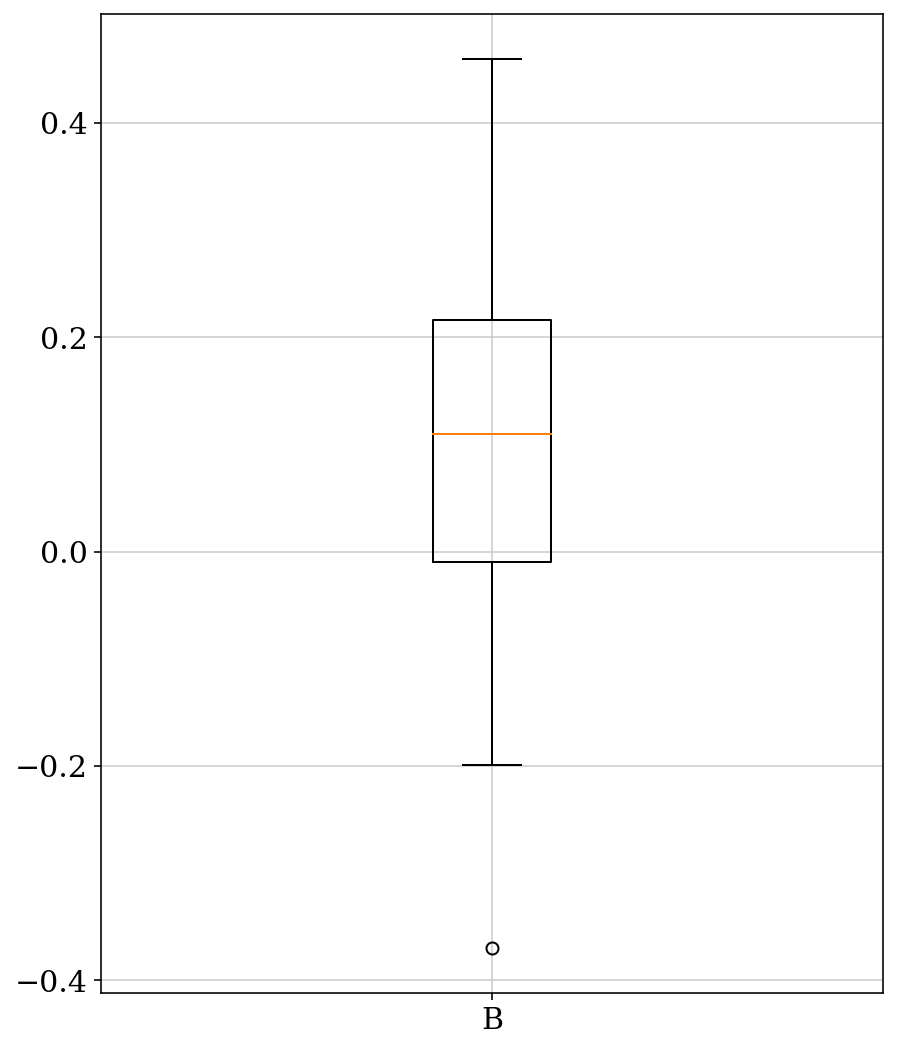

Figure 128: Difference between SIMBAD and our measurements


Shapiro-Wilk normality test
W = 0.979, p-value = 0.879
Interpretation of results: if p_value is larger than 0.05 then there is no evidence that distributino is not normal, and we can proceed with paired sample t-test.


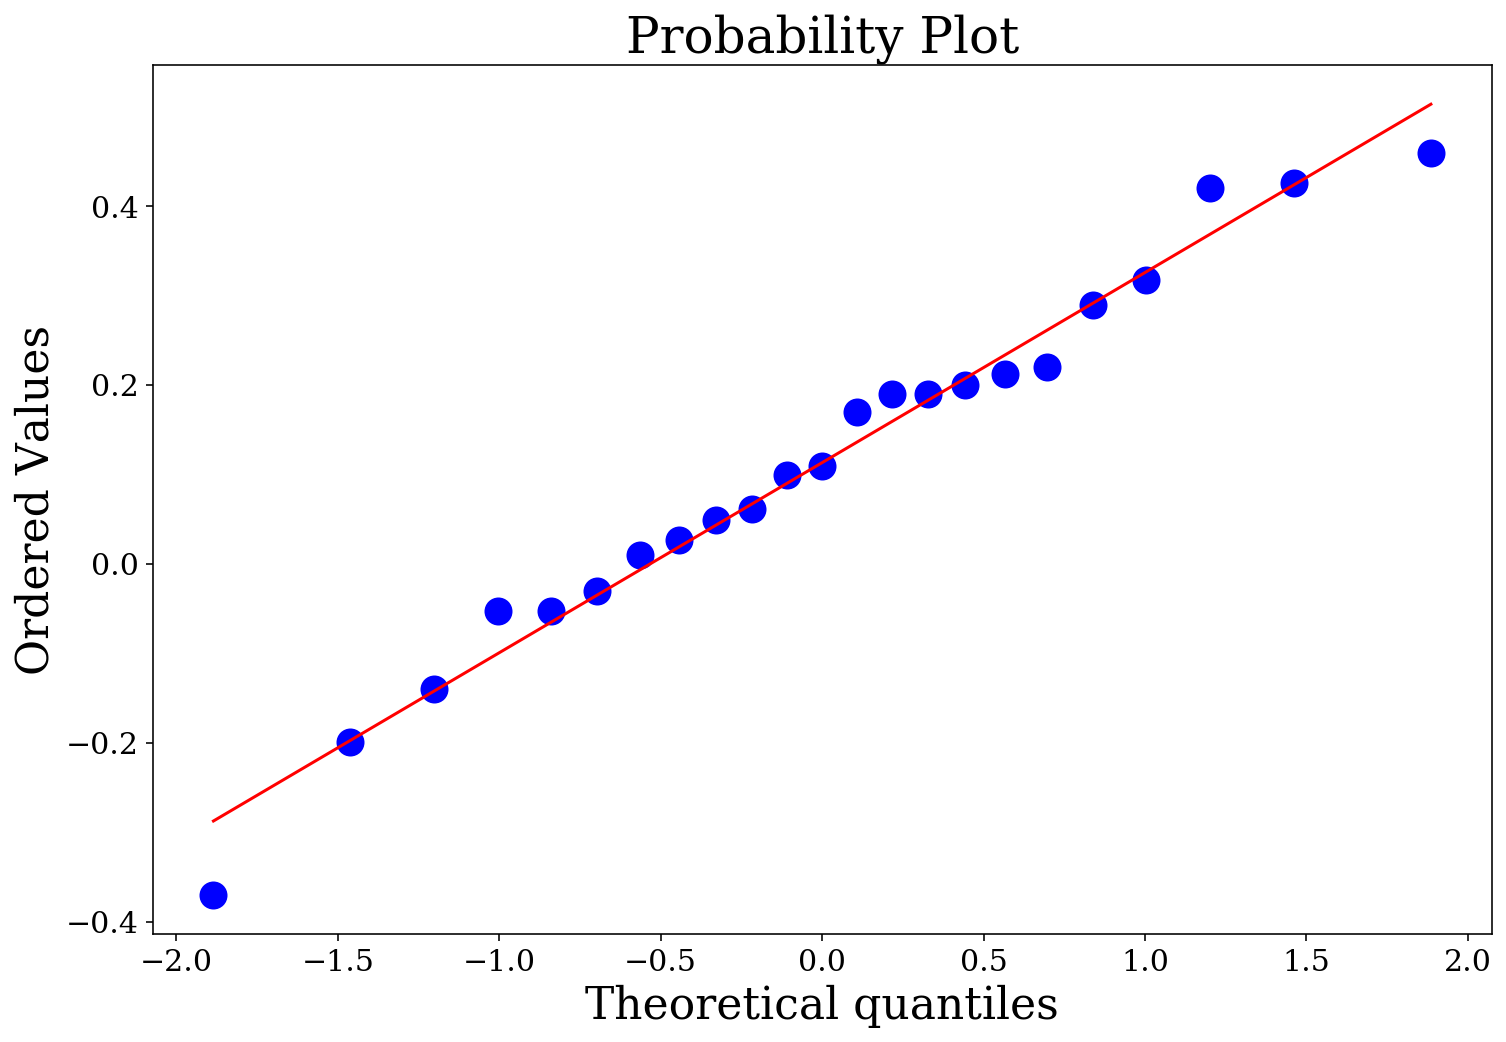

Figure 129: Normal Quantile-Quantile Plot. If markers are laying close to straight line then the distribution is closer to normal.


Paired sample t-test: t-statistic=2.713, df=22, p-value=0.00635
Interpretation of results: if p_value is smaller than 0.05 then the difference between the SIMBAD's and our measurements is statistically significant.


In [8]:
figure_number += 1

check_significance(df=df_check_stars, figure_number=figure_number, filter_name="B",
                   min_value=-0.6, max_value=0.6)

figure_number += 2

## Check significance of difference in B-magnitude between SIMBAD and our measurements

### Checking for normality

First, we verify the assumption that our values are normally distributed, so that we can apply the paired sample t-test. Shapiro-Wilk normality test gives p-value of 0.879. Since this is much larger than 0.05, we can not reject the null-hypothesis that the values are normally distributed. Moreover, the dots are located close to the straight line on the quantile-quantile plot on Fig. 129. This suggests distribution of our data are close to normal and that we can use paired sample t-test.


### Confidence interval

Next, we calculate confidence interval of the mean for 95% confidence level:

* 95% confidence interval: (0.02, 0.20).

Conclusion: There is 0.95 probability that our confidence interval contains true population mean. Our data show significant evidence that the mean B values that we measured are higher than those from SIMBAD.



## Statistical test

We want to test if the mean B value that we measured ($\mu_{\text{us}}$) is higher than that from SIMBAD ($ \mu_{\text{simbad}}$) using paired sample t-test.


### Hypotheses

Null hypothesis $H_0: \mu_{\text{us}} = \mu_{\text{simbad}}$.

Alternative hypothesis $H_A: \mu_{\text{us}} > \mu_{\text{simbad}}$.

Significance level: 95%.


### Verifying assumptions

* Dependent variable is continuous: yes.

* The observations are independent of one another: yes, since we made independent measurements of magnitudes.

* The dependent variable does not contain any outliers: true, after we excluded two outliers: -0.85, 0.73.

* The dependent variable is approximately normally distributed: yes, Fig. 129 and Shapiro-Wilk test provide evidence for normality.


### Results and conclusion

The p-value of the test is 0.00635, therefore, we can reject the null hypothesis $H_0$. In other words, if we assume that the mean of SIMBAD's and our magnitude measurements are the same, then there is 0.00635 probability that we would observe our data purely by chance. Since this probability is much smaller than 0.05, we conclude that our data show statistically significant evidence (at 95% significance level) that mean B magnitudes that we measured are higher than those from SIMBAD.


## Check significance of difference in B-V color between SIMBAD and our measurements



----------------
Statistical significance test for difference between SIMBAD and our measurements
Filter: B-V
Excluding outliters: [-0.48, -0.01, -0.19]
Mean: 0.20
Standard error of the mean: 0.01
95% confidence interval: (0.17, 0.23)


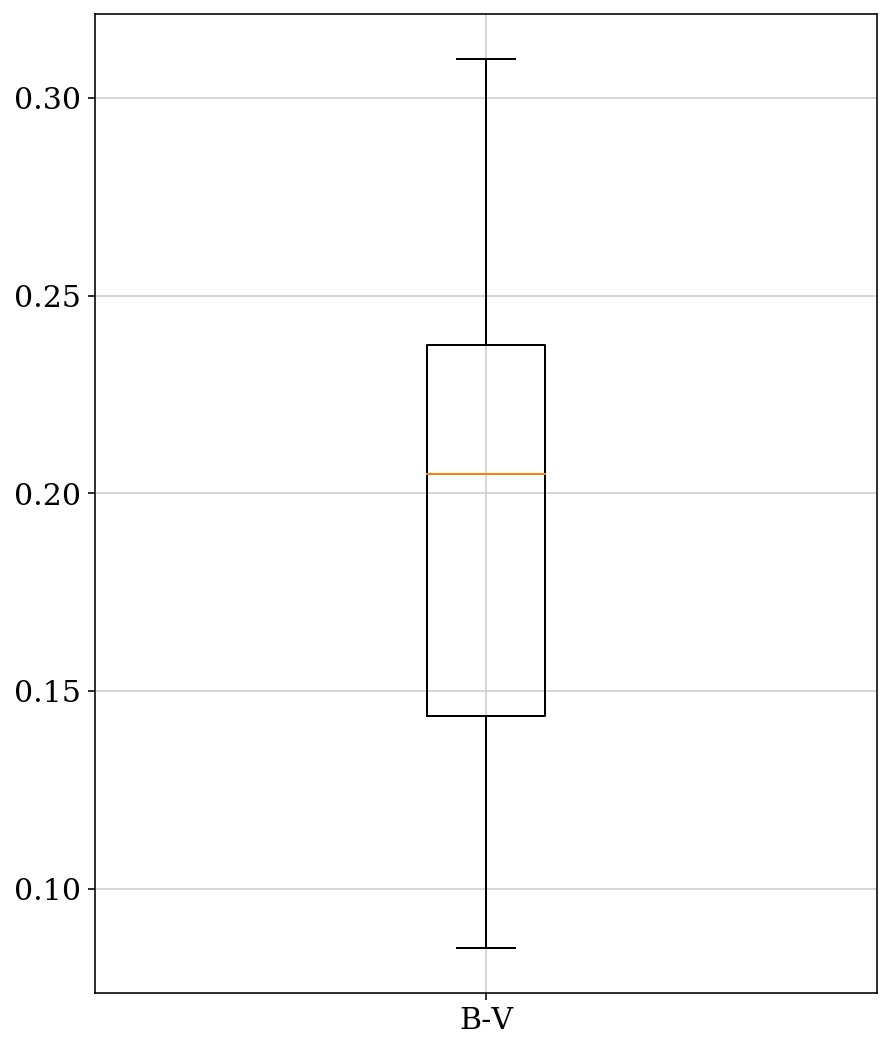

Figure 131: Difference between SIMBAD and our measurements


Shapiro-Wilk normality test
W = 0.977, p-value = 0.915
Interpretation of results: if p_value is larger than 0.05 then there is no evidence that distributino is not normal, and we can proceed with paired sample t-test.


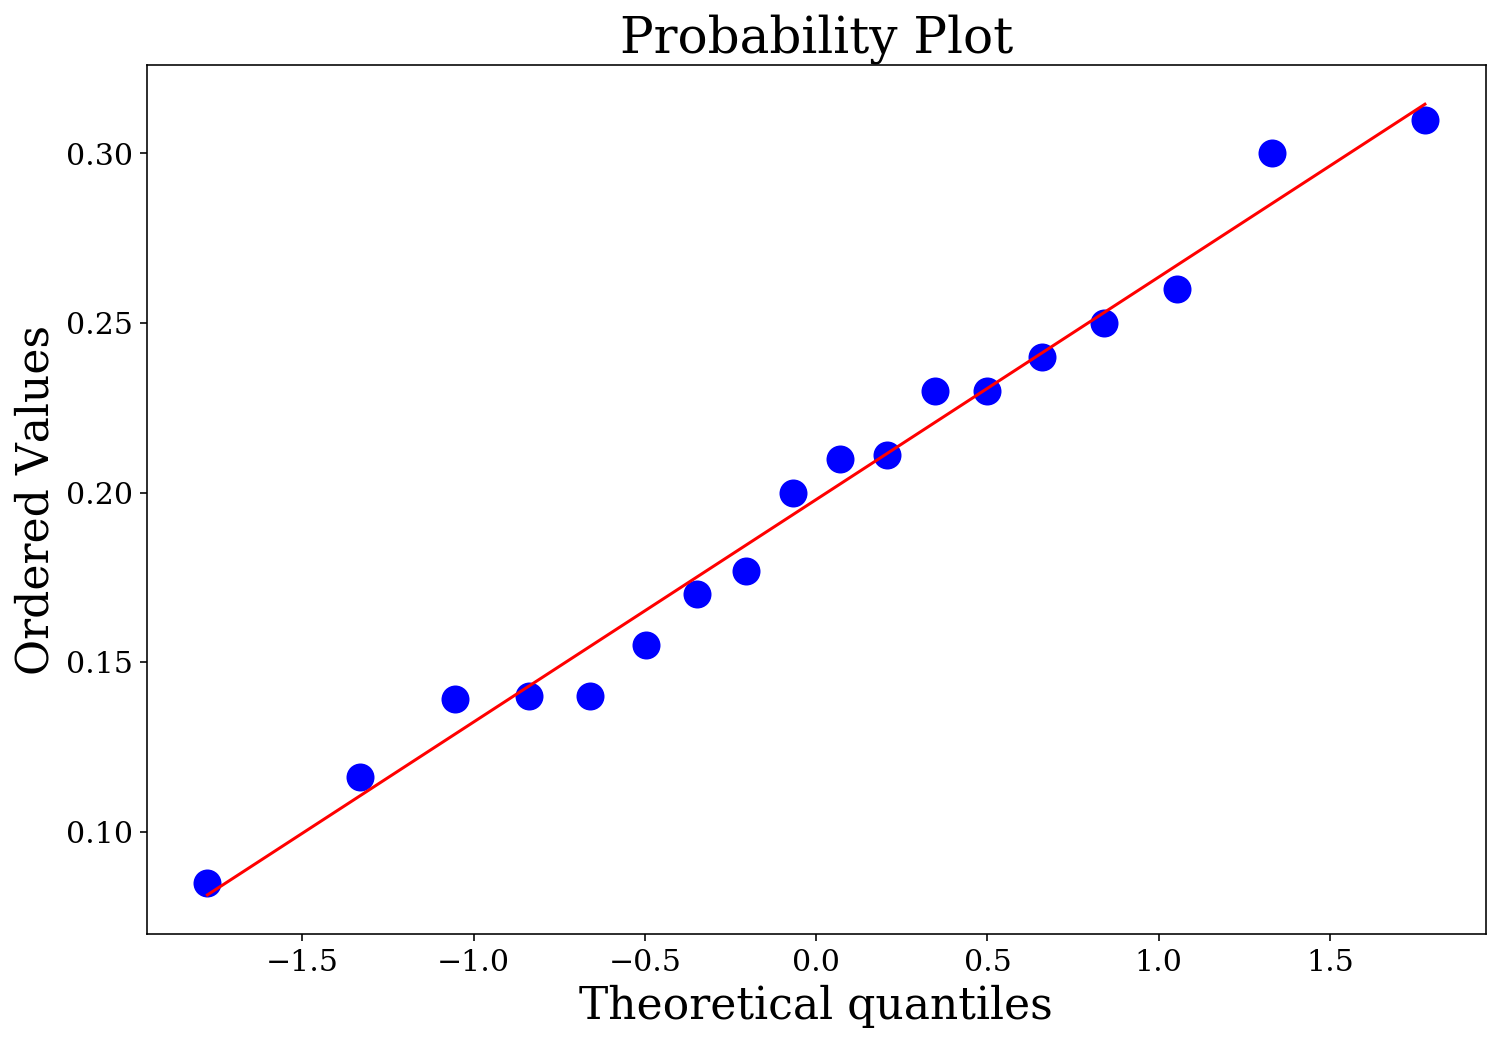

Figure 132: Normal Quantile-Quantile Plot. If markers are laying close to straight line then the distribution is closer to normal.


Paired sample t-test: t-statistic=13.827, df=17, p-value=0.00000
Interpretation of results: if p_value is smaller than 0.05 then the difference between the SIMBAD's and our measurements is statistically significant.


In [9]:
figure_number += 1

check_significance(df=df_check_stars, figure_number=figure_number, filter_name="B-V",
                   min_value=0, max_value=0.4)

figure_number += 2

## Check significance of difference in B-V color between SIMBAD and our measurements

### Checking for normality

First, we verify the assumption that our values are normally distributed, so that we can apply the paired sample t-test. Shapiro-Wilk normality test gives p-value of 0.915. Since this is much larger than 0.05, we can not reject the null-hypothesis that the values are normally distributed. Moreover, the dots are located close to the straight line on the quantile-quantile plot on Fig. 132. This suggests distribution of our data are close to normal and that we can use paired sample t-test.


### Confidence interval

Next, we calculate confidence interval of the mean for 95% confidence level:

* 95% confidence interval: (0.17, 0.23).

Conclusion: There is 0.95 probability that our confidence interval contains true population mean. Our data show significant evidence that the mean B values that we measured are higher than those from SIMBAD.



## Statistical test

We want to test if the mean B value that we measured ($\mu_{\text{us}}$) is higher than that from SIMBAD ($ \mu_{\text{simbad}}$) using paired sample t-test.


### Hypotheses

Null hypothesis $H_0: \mu_{\text{us}} = \mu_{\text{simbad}}$.

Alternative hypothesis $H_A: \mu_{\text{us}} > \mu_{\text{simbad}}$.

Significance level: 95%.


### Verifying assumptions

* Dependent variable is continuous: yes.

* The observations are independent of one another: yes, since we made independent measurements of magnitudes.

* The dependent variable does not contain any outliers: true, after we excluded two outliers: -0.48, -0.01, -0.19.

* The dependent variable is approximately normally distributed: yes, Fig. 132 and Shapiro-Wilk test provide evidence for normality.


### Results and conclusion

The p-value of the test is close to zero, therefore, we can reject the null hypothesis $H_0$. In other words, if we assume that the mean of SIMBAD's and our magnitude measurements are the same, then there is almost zero probability that we would observe our data purely by chance. Therefore, we conclude that our data show statistically significant evidence (at 95% significance level) that mean B magnitudes that we measured are higher than those from SIMBAD.

In [10]:
print("We are done!")

We are done!
